In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL


In [30]:
df = pd.read_csv('../dataset/final_data.csv', usecols=['DATE', 'Precip'])
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)
df = df.resample('ME', label='left', closed='left').sum()

We will try to do some anomaly detection in the following section.
The first method I'm exploring is Seasonal Trend Decomposition based on LOESS(STL)
LOESS stands for Locally estimated scatterplot smoothing.

This technique gives us the ability to split time series signal into three parts: seasonal, trend, and residue.

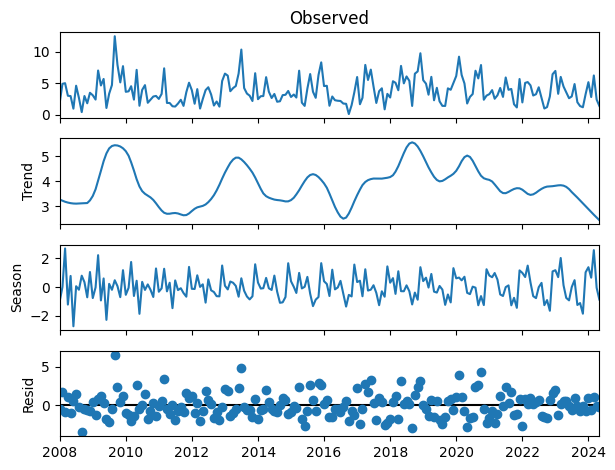

In [31]:
stl = STL(df, seasonal=13)
res = stl.fit()
fig = res.plot()

I have hourly rainfall data, say 'DATE' and 'Precip' column from 2008 to 2024. 
Write python code to determine each of the following information, we should be able to 
understand results be it in terms of graphs or as quantity values.

- Information I can extract from rain data
- I have rain data for more or less 13 to 14 years
- I can get info on how's rainfall pattern changing year by year
- Is there pattern of rainfall per month, whether some months have more rain than others
- Is there some torrential rainfall on certain time of months or some days 
- How about the frequency of high rainfall
- what can i obtain via fft?
- Is there any kind of abonormal rain somewhere?

/var/folders/j3/9_pszf256zvgnry9z0x72k_h0000gn/T/ipykernel_83923/3014983907.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_rainfall = df.resample('Y')['Precip'].sum()


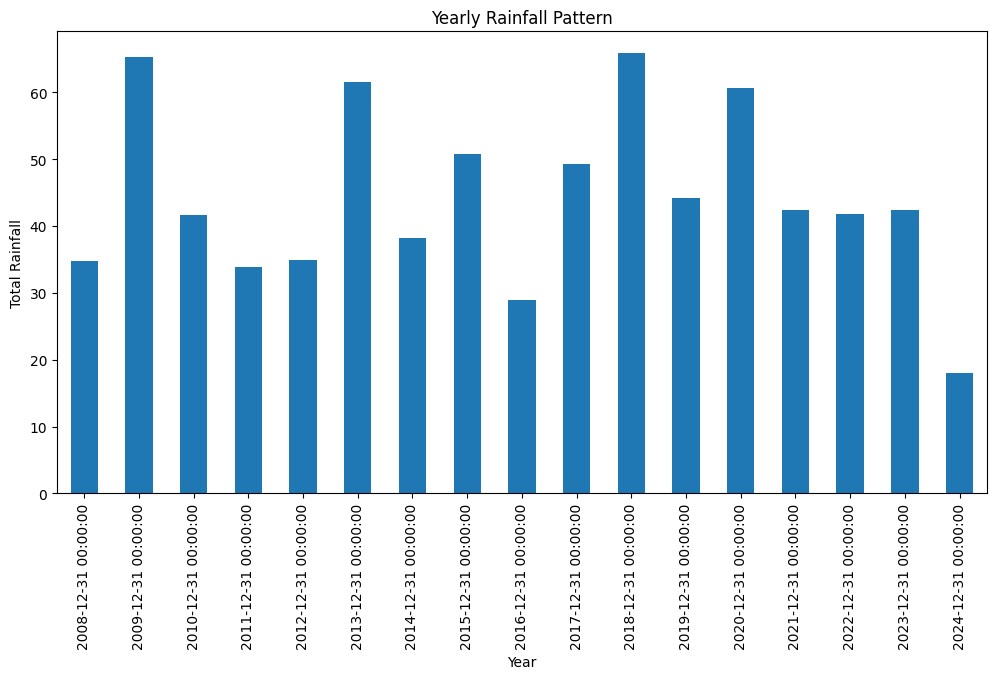

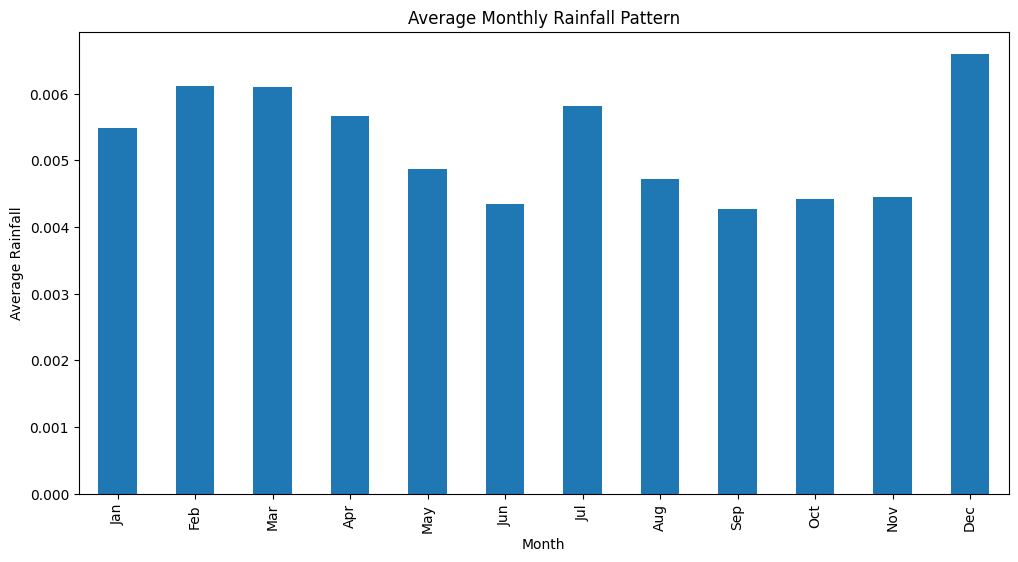

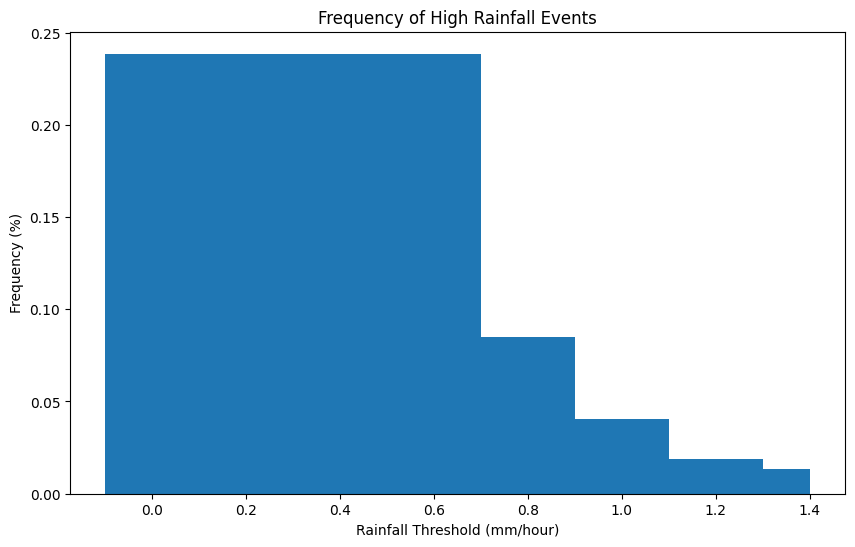

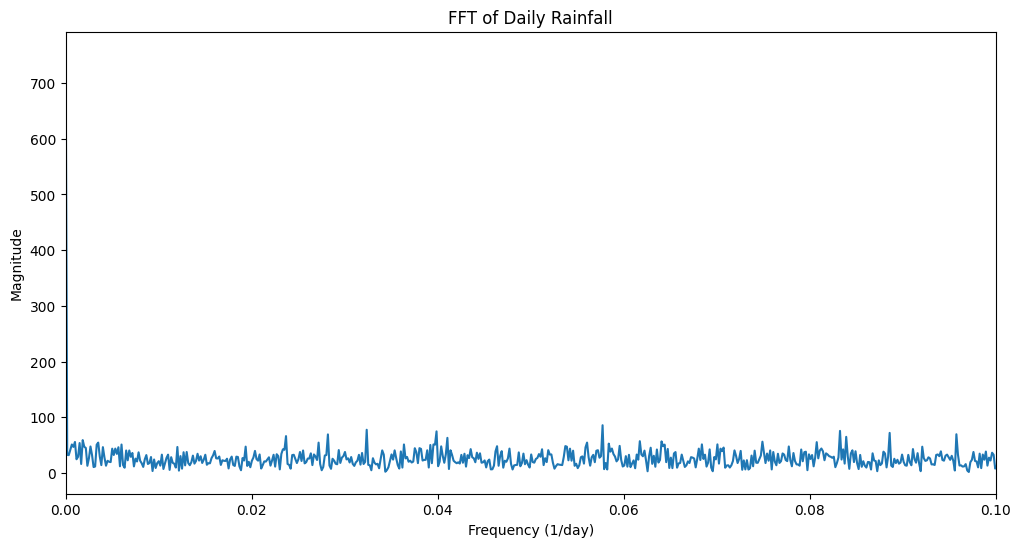

Number of abnormal rainfall events: 1931

Top 10 most abnormal rainfall events:
                     Precip    Z_score
DATE                                  
2018-05-20 17:00:00    1.81  52.326527
2020-07-09 20:00:00    1.75  50.586903
2010-08-26 04:00:00    1.52  43.918344
2010-05-03 05:00:00    1.30  37.539723
2009-05-16 12:00:00    1.27  36.669911
2013-06-05 22:00:00    1.22  35.220224
2014-07-24 17:00:00    1.15  33.190663
2010-05-03 06:00:00    1.10  31.740976
2020-10-24 18:00:00    1.10  31.740976
2017-06-15 18:00:00    1.09  31.451039


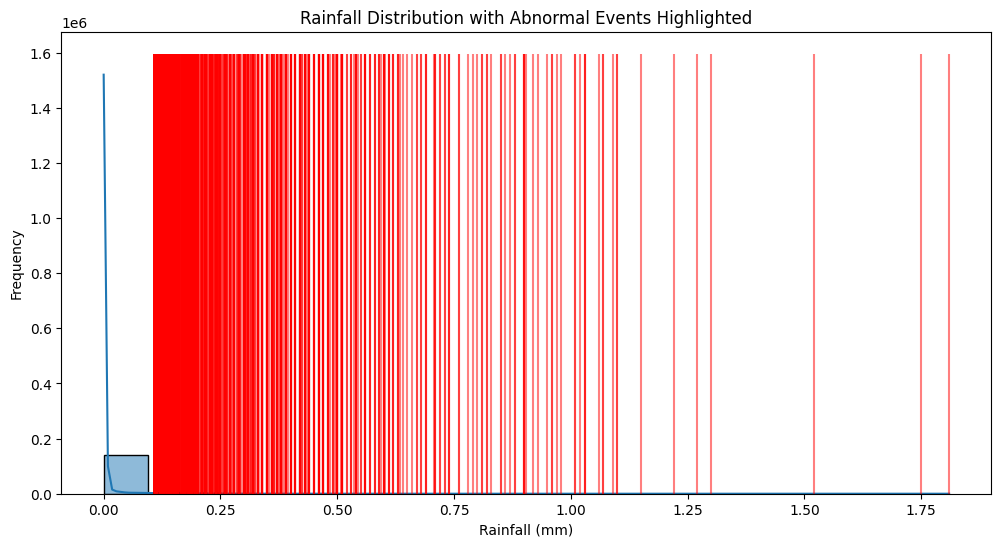

In [34]:
from scipy.fft import fft
import seaborn as sns

df = pd.read_csv('../dataset/final_data.csv', usecols=['DATE', 'Precip'])
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)

# 1. Rainfall pattern changing year by year
def yearly_rainfall_pattern():
    yearly_rainfall = df.resample('Y')['Precip'].sum()
    plt.figure(figsize=(12, 6))
    yearly_rainfall.plot(kind='bar')
    plt.title('Yearly Rainfall Pattern')
    plt.xlabel('Year')
    plt.ylabel('Total Rainfall')
    plt.show()

# 2. Monthly rainfall pattern
def monthly_rainfall_pattern():
    monthly_rainfall = df.groupby(df.index.month)['Precip'].mean()
    plt.figure(figsize=(12, 6))
    monthly_rainfall.plot(kind='bar')
    plt.title('Average Monthly Rainfall Pattern')
    plt.xlabel('Month')
    plt.ylabel('Average Rainfall')
    plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.show()

# 3. Torrential rainfall pattern
def torrential_rainfall_pattern():
    # Define torrential rainfall (e.g., more than 50mm in an hour)
    torrential_threshold = 50
    torrential_rain = df[df['Precip'] > torrential_threshold]
    
    plt.figure(figsize=(12, 6))
    torrential_rain.groupby(torrential_rain.index.month)['Precip'].count().plot(kind='bar')
    plt.title('Torrential Rainfall Occurrences by Month')
    plt.xlabel('Month')
    plt.ylabel('Number of Torrential Rainfall Events')
    plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.show()

# 4. Frequency of high rainfall
def high_rainfall_frequency():
    rainfall_thresholds = [0.3, 0.5, 0.7, 0.9, 1.0]  # inch/hour
    frequencies = []
    
    for threshold in rainfall_thresholds:
        frequency = (df['Precip'] > threshold).sum() / len(df) * 100
        frequencies.append(frequency)
    
    plt.figure(figsize=(10, 6))
    plt.bar(rainfall_thresholds, frequencies)
    plt.title('Frequency of High Rainfall Events')
    plt.xlabel('Rainfall Threshold (mm/hour)')
    plt.ylabel('Frequency (%)')
    plt.show()

# 5. FFT analysis
def rainfall_fft():
    # Resample to daily data for FFT
    daily_rainfall = df.resample('D')['Precip'].sum()
    
    # Perform FFT
    fft_result = fft(daily_rainfall.values)
    frequencies = np.fft.fftfreq(len(daily_rainfall), d=1)
    
    plt.figure(figsize=(12, 6))
    plt.plot(frequencies[:len(frequencies)//2], np.abs(fft_result)[:len(frequencies)//2])
    plt.title('FFT of Daily Rainfall')
    plt.xlabel('Frequency (1/day)')
    plt.ylabel('Magnitude')
    plt.xlim(0, 0.1)  # Focus on lower frequencies
    plt.show()

# 6. Abnormal rainfall detection
def detect_abnormal_rainfall():
    # Calculate Z-score for each rainfall measurement
    mean_rainfall = df['Precip'].mean()
    std_rainfall = df['Precip'].std()
    df['Z_score'] = (df['Precip'] - mean_rainfall) / std_rainfall
    
    # Define abnormal as Z-score > 3 (3 standard deviations from mean)
    abnormal_rain = df[df['Z_score'] > 3]
    
    print(f"Number of abnormal rainfall events: {len(abnormal_rain)}")
    print("\nTop 10 most abnormal rainfall events:")
    print(abnormal_rain.sort_values('Z_score', ascending=False).head(10))

    # Plot histogram of rainfall with abnormal events highlighted
    plt.figure(figsize=(12, 6))
    sns.histplot(df['Precip'], kde=True)
    plt.vlines(abnormal_rain['Precip'], ymin=0, ymax=plt.ylim()[1], color='red', alpha=0.5)
    plt.title('Rainfall Distribution with Abnormal Events Highlighted')
    plt.xlabel('Rainfall (mm)')
    plt.ylabel('Frequency')
    plt.show()

# Run all analyses
yearly_rainfall_pattern()
monthly_rainfall_pattern()
#torrential_rainfall_pattern()
high_rainfall_frequency()
rainfall_fft()
detect_abnormal_rainfall()

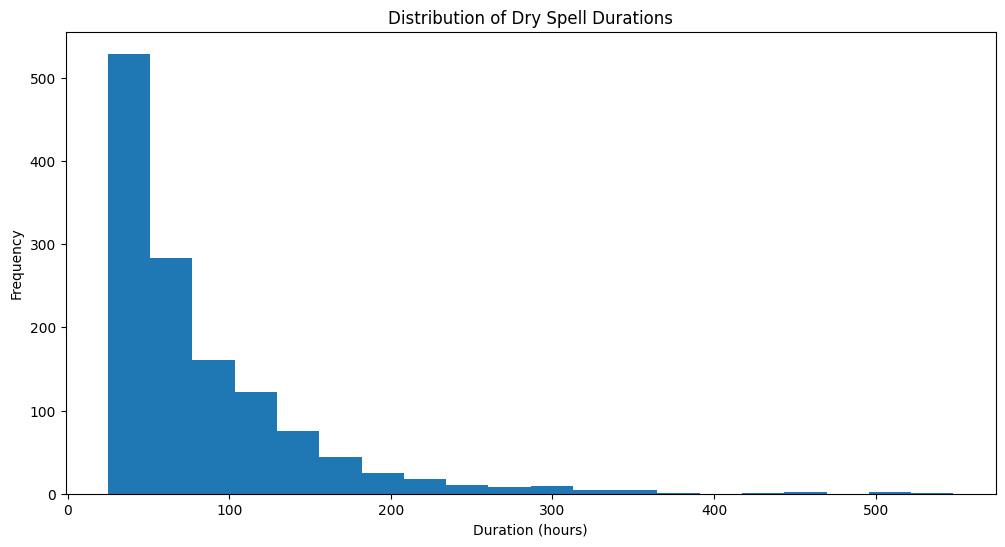

Average dry spell duration: 82.13 hours
Longest dry spell: 548 hours


ValueError: Grouper and axis must be same length

In [41]:
from scipy.stats import linregress
from statsmodels.tsa.seasonal import seasonal_decompose


# 1. Dry spells analysis
def analyze_dry_spells():
    df['is_dry'] = df['Precip'] == 0
    dry_spells = df['is_dry'].groupby((df['is_dry'] != df['is_dry'].shift()).cumsum()).sum()
    dry_spells = dry_spells[dry_spells > 24]  # Consider dry spells longer than 24 hours
    
    plt.figure(figsize=(12, 6))
    plt.hist(dry_spells, bins=20)
    plt.title('Distribution of Dry Spell Durations')
    plt.xlabel('Duration (hours)')
    plt.ylabel('Frequency')
    plt.show()
    
    print(f"Average dry spell duration: {dry_spells.mean():.2f} hours")
    print(f"Longest dry spell: {dry_spells.max()} hours")

# 2. Rainfall intensity trends
def analyze_rainfall_intensity():
    yearly_intensity = df[df['Precip'] > 0].groupby(df.index.year)['Precip'].mean()
    
    plt.figure(figsize=(12, 6))
    yearly_intensity.plot()
    plt.title('Yearly Average Rainfall Intensity')
    plt.xlabel('Year')
    plt.ylabel('Average Intensity (mm/hour)')
    
    # Linear regression to show trend
    x = yearly_intensity.index
    y = yearly_intensity.values
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    plt.plot(x, intercept + slope*x, 'r', label=f'Trend (p={p_value:.4f})')
    plt.legend()
    plt.show()

# 3. Seasonal shift analysis
def analyze_seasonal_shift():
    monthly_rainfall = df.groupby([df.index.year, df.index.month])['Precip'].sum().unstack()
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(monthly_rainfall, cmap='YlGnBu')
    plt.title('Monthly Rainfall Heatmap')
    plt.xlabel('Month')
    plt.ylabel('Year')
    plt.show()

# 4. Weekly patterns
def analyze_weekly_patterns():
    daily_rainfall = df.resample('D')['Precip'].sum()
    weekday_rainfall = daily_rainfall.groupby(daily_rainfall.index.dayofweek).mean()
    
    plt.figure(figsize=(10, 6))
    weekday_rainfall.plot(kind='bar')
    plt.title('Average Daily Rainfall by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Average Rainfall (mm)')
    plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.show()

# 5. Diurnal patterns
def analyze_diurnal_patterns():
    hourly_rainfall = df.groupby(df.index.hour)['Precip'].mean()
    
    plt.figure(figsize=(12, 6))
    hourly_rainfall.plot(kind='bar')
    plt.title('Average Hourly Rainfall')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Rainfall (mm)')
    plt.show()

# 6. Annual rainfall variability
def analyze_annual_variability():
    yearly_rainfall = df.resample('Y')['Precip'].sum()
    
    plt.figure(figsize=(12, 6))
    yearly_rainfall.plot()
    plt.title('Total Annual Rainfall')
    plt.xlabel('Year')
    plt.ylabel('Total Rainfall (mm)')
    
    # Calculate and plot the trend
    x = np.arange(len(yearly_rainfall))
    y = yearly_rainfall.values
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(yearly_rainfall.index, p(x), "r--", label='Trend')
    
    # Calculate and plot the variability
    variability = yearly_rainfall.rolling(window=5).std()
    plt.plot(variability.index, variability.values, 'g-', label='5-year Rolling Std Dev')
    
    plt.legend()
    plt.show()

# 7. Cumulative rainfall analysis
def analyze_cumulative_rainfall():
    yearly_cumulative = df.groupby(df.index.year)['Precip'].cumsum().unstack()
    normalized_cumulative = yearly_cumulative.divide(yearly_cumulative.iloc[-1])
    
    plt.figure(figsize=(12, 6))
    normalized_cumulative.plot()
    plt.title('Normalized Cumulative Rainfall by Year')
    plt.xlabel('Day of Year')
    plt.ylabel('Fraction of Annual Rainfall')
    plt.show()

# 8. Trend break detection
def detect_trend_breaks():
    monthly_rainfall = df.resample('M')['Precip'].sum()
    result = seasonal_decompose(monthly_rainfall, model='additive', period=12)
    
    plt.figure(figsize=(12, 10))
    plt.subplot(411)
    plt.plot(monthly_rainfall)
    plt.title('Original Time Series')
    plt.subplot(412)
    plt.plot(result.trend)
    plt.title('Trend')
    plt.subplot(413)
    plt.plot(result.seasonal)
    plt.title('Seasonal')
    plt.subplot(414)
    plt.plot(result.resid)
    plt.title('Residuals')
    plt.tight_layout()
    plt.show()

# Run all new analyses
analyze_dry_spells()
#analyze_rainfall_intensity()
analyze_seasonal_shift()
analyze_weekly_patterns()
analyze_diurnal_patterns()
analyze_annual_variability()
analyze_cumulative_rainfall()
detect_trend_breaks()

In [42]:
548/24

22.833333333333332

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.ensemble import RandomForestRegressor

# Assuming df is your DataFrame with 'DATE' as index and 'Precip' as the target column

# 1. ARIMA (AutoRegressive Integrated Moving Average)
def arima_forecast(data, order=(1,1,1), forecast_steps=30):
    model = ARIMA(data, order=order)
    results = model.fit()
    forecast = results.forecast(steps=forecast_steps)
    
    plt.figure(figsize=(12,6))
    plt.plot(data.index, data, label='Observed')
    plt.plot(forecast.index, forecast, color='r', label='Forecast')
    plt.title('ARIMA Forecast')
    plt.legend()
    plt.show()
    
    return forecast

# 2. SARIMA (Seasonal ARIMA)
def sarima_forecast(data, order=(1,1,1), seasonal_order=(1,1,1,12), forecast_steps=30):
    model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
    results = model.fit()
    forecast = results.forecast(steps=forecast_steps)
    
    plt.figure(figsize=(12,6))
    plt.plot(data.index, data, label='Observed')
    plt.plot(forecast.index, forecast, color='r', label='Forecast')
    plt.title('SARIMA Forecast')
    plt.legend()
    plt.show()
    
    return forecast

# 3. Prophet
def prophet_forecast(data, forecast_days=30):
    df_prophet = data.reset_index().rename(columns={'DATE': 'ds', 'Precip': 'y'})
    model = Prophet()
    model.fit(df_prophet)
    
    future = model.make_future_dataframe(periods=forecast_days)
    forecast = model.predict(future)
    
    fig = model.plot(forecast)
    plt.title('Prophet Forecast')
    plt.show()
    
    return forecast

# 4. LSTM (Long Short-Term Memory)
def lstm_forecast(data, lookback=30, forecast_days=30):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))
    
    X, y = [], []
    for i in range(len(scaled_data) - lookback):
        X.append(scaled_data[i:i+lookback])
        y.append(scaled_data[i+lookback])
    X, y = np.array(X), np.array(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(lookback, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=0)
    
    # Make predictions
    last_sequence = scaled_data[-lookback:].reshape(1, lookback, 1)
    forecast = []
    for _ in range(forecast_days):
        next_pred = model.predict(last_sequence)
        forecast.append(next_pred[0,0])
        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0,-1,0] = next_pred[0,0]
    
    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
    
    plt.figure(figsize=(12,6))
    plt.plot(data.index[-100:], data.values[-100:], label='Observed')
    plt.plot(pd.date_range(start=data.index[-1], periods=forecast_days+1, closed='right'), 
             forecast, color='r', label='Forecast')
    plt.title('LSTM Forecast')
    plt.legend()
    plt.show()
    
    return forecast

# 5. Random Forest
def random_forest_forecast(data, lookback=30, forecast_days=30):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data.iloc[i:i+lookback].values)
        y.append(data.iloc[i+lookback])
    X, y = np.array(X), np.array(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    last_sequence = data.iloc[-lookback:].values.reshape(1, -1)
    forecast = []
    for _ in range(forecast_days):
        next_pred = model.predict(last_sequence)
        forecast.append(next_pred[0])
        last_sequence = np.roll(last_sequence, -1)
        last_sequence[0,-1] = next_pred[0]
    
    plt.figure(figsize=(12,6))
    plt.plot(data.index[-100:], data.values[-100:], label='Observed')
    plt.plot(pd.date_range(start=data.index[-1], periods=forecast_days+1, closed='right'), 
             forecast, color='r', label='Forecast')
    plt.title('Random Forest Forecast')
    plt.legend()
    plt.show()
    
    return forecast

# Example usage:
# Resample to daily data for these examples
daily_rainfall = df.resample('D')['Precip'].sum()

arima_forecast(daily_rainfall)
sarima_forecast(daily_rainfall)
#prophet_forecast(daily_rainfall)
lstm_forecast(daily_rainfall)
random_forest_forecast(daily_rainfall)

ModuleNotFoundError: No module named 'tensorflow'